# **ADVANCED SVD**

### **1. Funk SVD**

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
ratings = pd.read_csv("../data/ratings.csv")
movies  = pd.read_csv("../data/movies.csv")

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [4]:
ratings.describe()

,userId,movieId,rating,timestamp
count,2.500010e+07,2.500010e+07,2.500010e+07,2.500010e+07
mean,8.118928e+04,2.138798e+04,3.533854e+00,1.215601e+09
std,4.679172e+04,3.919886e+04,1.060744e+00,2.268758e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.196000e+03,3.000000e+00,1.011747e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.198868e+09
75%,1.215570e+05,8.623000e+03,4.000000e+00,1.447205e+09
max,1.625410e+05,2.091710e+05,5.000000e+00,1.574328e+09


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings['userId'].value_counts()

userId
72315     32202
80974      9178
137293     8913
33844      7919
20055      7488
          ...  
12094        20
119539       20
156759       20
12084        20
36207        20
Name: count, Length: 162541, dtype: int64

In [7]:
# Kiểm tra user “ít rating” nhất
min_ratings = ratings['userId'].value_counts().min()
print(min_ratings)

20


In [8]:
df = ratings.merge(movies, on='movieId', how='left')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,1147878820,Underground (1995),Comedy|Drama|War
4,1,899,3.5,1147868510,Singin' in the Rain (1952),Comedy|Musical|Romance


- `LabelEncoder` mã hóa `userId` và `movieId` (các giá trị không liên tiếp, ví dụ: 1234, 5678) thành chỉ số liên tiếp (0, 1, 2, ...).

- Sau đó tạo cột `user_idx` với chỉ số người dùng (0 đến 162,540) và cột `movie_idx` với chỉ số phim (0 đến 62,422).


In [9]:
user_enc  = LabelEncoder()
movie_enc = LabelEncoder()

df['user_idx']  = user_enc.fit_transform(df['userId'])
df['movie_idx'] = movie_enc.fit_transform(df['movieId'])

df.head()

,userId,movieId,rating,timestamp,title,genres,user_idx,movie_idx
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0,292
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama,0,302
2,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama,0,303
3,1,665,5.0,1147878820,Underground (1995),Comedy|Drama|War,0,654
4,1,899,3.5,1147868510,Singin' in the Rain (1952),Comedy|Musical|Romance,0,878


In [10]:
n_users  = df["user_idx"].nunique()
n_items  = df["movie_idx"].nunique()
print(f"Dataset: {len(df):,} ratings | {n_users:,} users | {n_items:,} movies")

Dataset: 25,000,095 ratings | 162,541 users | 59,047 movies


In [11]:
# tách test 20 %, val 10 % còn lại
train_val_df, test_df = train_test_split(
    df[["user_idx", "movie_idx", "rating"]],
    test_size=0.2,
    random_state=42,
    stratify=df["user_idx"], # đảm bảo mỗi user vẫn còn dữ liệu ở cả train lẫn test (tránh trường hợp một user chỉ rơi hết vào train hoặc hết vào test)
)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1,
    random_state=42,
    stratify=train_val_df["user_idx"],
)

Hàm `df_to_numpy()` dùng để chuyển DataFrame sang NumPy

In [12]:
def df_to_numpy(df_):
    arr = df_[["user_idx", "movie_idx", "rating"]].to_numpy()
    return arr[:, 0].astype(np.int32), arr[:, 1].astype(np.int32), arr[:, 2].astype(np.float32)

### **Thuật toán FunkSVD**

- **Mục tiêu:** Xấp xỉ ma trận đánh giá thưa $$ R \in \mathbb{R}^{n_{\text{users}} \times n_{\text{items}}} $$ bằng tích của hai ma trận yếu tố ẩn  
  $$ P \in \mathbb{R}^{n_{\text{users}} \times k}, \quad Q \in \mathbb{R}^{n_{\text{items}} \times k}, \quad R \approx PQ^T $$

- **Dự đoán:** Điểm đánh giá dự đoán cho người dùng $ u $ và phim $ i $:

  $$
  \hat{r}_{ui} = \mu + b_u + b_i + P_u \cdot Q_i
  $$

  Trong đó:

  - $\mu $: Trung bình toàn bộ đánh giá (global bias).
  - $ b_u $: Bias của người dùng $u$ (xu hướng đánh giá cao/thấp).
  - $ b_i $: Bias của phim $ i $ (xu hướng được đánh giá cao/thấp).
  - $ P_u \cdot Q_i $: Tích vô hướng của vector yếu tố ẩn (kích thước $ k $).

- **Hàm mất mát:** Tối thiểu hóa sai số bình phương với điều chuẩn riêng cho bias và yếu tố ẩn:

  $
  L = \sum_{(u,i) \in \text{known ratings}} (r_{ui} - \hat{r}_{ui})^2 + \lambda_{bu,bi} \left( \sum_u b_u^2 + \sum_i b_i^2 \right) + \lambda_{pq} \left( \sum_u \| P_u \|^2 + \sum_i \| Q_i \|^2 \right)
  $

  Trong đó:

  - $ (r_{ui} - \hat{r}_{ui})^2 $: Sai số bình phương.
  - $ \lambda_{bu,bi} $: Hệ số điều chuẩn cho bias (`reg_bu_bi`).
  - $ \lambda_{pq} $: Hệ số điều chuẩn cho yếu tố ẩn (`reg_pq`).
  - $ b_u^2, b_i^2, \|P_u\|^2, \|Q_i\|^2 $: Phạt các giá trị lớn để tránh overfitting.

- **Tối ưu hóa:** Sử dụng SGD để cập nhật $ \mu, b_u, b_i, P_u, Q_i $ từng mẫu dữ liệu một cách ngẫu nhiên, với learning rate giảm dần (decay).


Code cũ chưa improve

In [13]:
# class FunkSVD:
#     def __init__(self, n_users, n_items, k=50,
#                  lr=0.007, reg=0.04, n_epochs=25,
#                  seed=42, verbose=True):
#         rng = np.random.default_rng(seed)
#         self.P  = 0.1 * rng.standard_normal((n_users, k))
#         self.Q  = 0.1 * rng.standard_normal((n_items, k))
#         self.bu = np.zeros(n_users)
#         self.bi = np.zeros(n_items)
#         self.mu = 0.0

#         self.lr0, self.lr = lr, lr
#         self.reg     = reg
#         self.n_epochs = n_epochs
#         self.verbose  = verbose
#         self.train_rmse = []
#         self.n_users = n_users
#         self.n_items = n_items
#         self.k = k
#         self.seed = seed

#     def fit(self, df, start_epoch=1):
#         """
#         Huấn luyện mô hình từ epoch start_epoch.
#         """
#         if start_epoch == 1:
#             self.mu = df['rating'].mean()
        
#         for ep in range(start_epoch, self.n_epochs + 1):
#             df = df.sample(frac=1.0, random_state=ep).reset_index(drop=True)
#             se = 0.0
#             for u, i, r in df.itertuples(index=False):
#                 pred = self.mu + self.bu[u] + self.bi[i] + self.P[u] @ self.Q[i]
#                 err  = r - pred
#                 se  += err**2
#                 pu_old = self.P[u].copy()
#                 self.bu[u] += self.lr * (err - self.reg * self.bu[u])
#                 self.bi[i] += self.lr * (err - self.reg * self.bi[i])
#                 self.P[u]  += self.lr * (err * self.Q[i] - self.reg * self.P[u])
#                 self.Q[i]  += self.lr * (err * pu_old    - self.reg * self.Q[i])
            
#             rmse = np.sqrt(se / len(df))
#             self.train_rmse.append(rmse)
#             if self.verbose:
#                 print(f"Epoch {ep:02d}/{self.n_epochs}  –  Train RMSE: {rmse:.4f}")
            
#             self.lr *= 0.95
        
#         return self

#     def predict(self, u_idx: int, i_idx: int) -> float:
#         est = (self.mu + self.bu[u_idx] + self.bi[u_idx] +
#                self.P[u_idx] @ self.Q[i_idx])
#         return float(np.clip(est, 0.5, 5.0))

#     def predict_batch(self, users, items):
#         return np.clip(
#             self.mu + self.bu[users] + self.bi[items] +
#             np.sum(self.P[users] * self.Q[items], axis=1),
#             0.5, 5.0
#         )

#     def save(self, filepath):
#         """
#         Lưu trạng thái mô hình vào file .npz.
#         """
#         np.savez(filepath,
#                  P=self.P,
#                  Q=self.Q,
#                  bu=self.bu,
#                  bi=self.bi,
#                  mu=self.mu,
#                  train_rmse=np.array(self.train_rmse),
#                  lr=self.lr,
#                  lr0=self.lr0,
#                  reg=self.reg,
#                  n_epochs=self.n_epochs,
#                  n_users=self.n_users,
#                  n_items=self.n_items,
#                  k=self.k,
#                  seed=self.seed,
#                  verbose=self.verbose)

#     def load(self, filepath):
#         """
#         Tải trạng thái mô hình từ file .npz.
#         """
#         data = np.load(filepath)
#         self.P = data['P']
#         self.Q = data['Q']
#         self.bu = data['bu']
#         self.bi = data['bi']
#         self.mu = data['mu']
#         self.train_rmse = list(data['train_rmse'])
#         self.lr = data['lr']
#         self.lr0 = data['lr0']
#         self.reg = data['reg']
#         self.n_epochs = int(data['n_epochs'])
#         self.n_users = int(data['n_users'])
#         self.n_items = int(data['n_items'])
#         self.k = int(data['k'])
#         self.seed = int(data['seed'])
#         self.verbose = bool(data['verbose'])
#         return self

Code mới

In [ ]:
class FunkSVD:

    def __init__(
        self,
        n_users: int,               # số người dùng
        n_items: int,               # số phim
        k: int = 50,                # yếu tố ẩn
        lr: float = 0.007,
        reg_bu_bi: float = 0.01,    # Hệ số điều chuẩn cho bias (b_u, b_i).
        reg_pq: float = 0.05,       # Hệ số điều chuẩn cho yếu tố ẩn (P, Q ).
        n_epochs: int = 35,
        seed: int = 42,
        verbose: bool = True,
    ):
        rng = np.random.default_rng(seed)
        # Ma trận yếu tố ẩn người dùng, khởi tạo ngẫu nhiên từ phân phối chuẩn, nhân 0.1 để giá trị nhỏ, kiểu float32.
        self.P  = 0.1 * rng.standard_normal((n_users, k)).astype(np.float32)
        # Ma trận yếu tố ẩn phim
        self.Q  = 0.1 * rng.standard_normal((n_items, k)).astype(np.float32)
        #---> Khởi tạo ngẫu nhiên P, Q với giá trị nhỏ tránh gradient lớn ban đầu.
        
        # Vector bias người dùng (b_u) -> khởi tạo = 0
        self.bu = np.zeros(n_users, dtype=np.float32)
        # Vector bias phim (b_i), khởi tạo = 0
        self.bi = np.zeros(n_items, dtype=np.float32)
        #  Global bias (\mu), khởi tạo = 0 
        self.mu = 0.0

        self.lr0 = self.lr = lr # Lưu tốc độ học ban đầu và hiện tại (sẽ giảm qua epoch)
        self.reg_bu_bi = reg_bu_bi
        self.reg_pq    = reg_pq
        self.n_epochs  = n_epochs
        self.verbose   = verbose
        self.train_rmse, self.val_rmse = [], []

    # ───── Train ─────
    def fit(self, train_df, val_df=None, patience: int = 3):
        u_tr, i_tr, r_tr = df_to_numpy(train_df)
        if val_df is not None:
            u_vl, i_vl, r_vl = df_to_numpy(val_df)

        self.mu = r_tr.mean()
        best_val = np.inf
        no_improve = 0

        for ep in range(1, self.n_epochs + 1):
            idx = np.random.permutation(len(r_tr))
            se = 0.0
            for u, i, r in zip(u_tr[idx], i_tr[idx], r_tr[idx]):
                pred = self.mu + self.bu[u] + self.bi[i] + self.P[u] @ self.Q[i]
                err  = r - pred
                se  += err * err

                # update bias
                self.bu[u] += self.lr * (err - self.reg_bu_bi * self.bu[u])
                self.bi[i] += self.lr * (err - self.reg_bu_bi * self.bi[i])

                # update latent factors
                pu_old = self.P[u].copy()
                self.P[u] += self.lr * (err * self.Q[i] - self.reg_pq * self.P[u])
                self.Q[i] += self.lr * (err * pu_old    - self.reg_pq * self.Q[i])

            rmse_tr = np.sqrt(se / len(r_tr))
            self.train_rmse.append(rmse_tr)

            # Validation
            if val_df is not None:
                preds = self.predict_batch(u_vl, i_vl)
                rmse_vl = np.sqrt(mean_squared_error(r_vl, preds))
                self.val_rmse.append(rmse_vl)

                if self.verbose:
                    print(f"Epoch {ep:02d}/{self.n_epochs} – Train {rmse_tr:.4f} | Val {rmse_vl:.4f}")

                # early-stopping
                if rmse_vl + 1e-4 < best_val:
                    best_val = rmse_vl
                    no_improve = 0
                    self._best_state = (self.P.copy(), self.Q.copy(), self.bu.copy(), self.bi.copy())
                else:
                    no_improve += 1
                    if no_improve >= patience:
                        if self.verbose:
                            print(">>> Early-stopping – restore best epoch.")
                        self.P, self.Q, self.bu, self.bi = self._best_state
                        break
            else:
                if self.verbose:
                    print(f"Epoch {ep:02d}/{self.n_epochs} – Train RMSE: {rmse_tr:.4f}")

            self.lr *= 0.95

        return self

    # ───── Inference ─────
    def predict(self, u_idx: int, i_idx: int) -> float:
        est = (
            self.mu
            + self.bu[u_idx]
            + self.bi[i_idx]                
            + self.P[u_idx] @ self.Q[i_idx]
        )
        return float(np.clip(est, 0.5, 5.0))

    def predict_batch(self, users, items):
        return np.clip(
            self.mu + self.bu[users] + self.bi[items] +
            np.einsum("ij,ij->i", self.P[users], self.Q[items]),
            0.5, 5.0,
        )

    # ───── Save / Load ─────
    def save(self, file_path: str):
        """
        Lưu mô hình ra file .npz. 
        """
        dir_name = os.path.dirname(file_path)
        if dir_name and not os.path.exists(dir_name):
            os.makedirs(dir_name, exist_ok=True)

        np.savez_compressed(
            file_path,
            P=self.P, Q=self.Q,
            bu=self.bu, bi=self.bi,
            mu=self.mu,
            train_rmse=np.array(self.train_rmse),
            val_rmse=np.array(self.val_rmse),
            lr=self.lr, lr0=self.lr0,
            reg_bu_bi=self.reg_bu_bi,
            reg_pq=self.reg_pq,
        )

    def load(self, file_path: str):
        """
        Khôi phục model từ file .npz.
        """
        data = np.load(file_path)
        self.P  = data["P"];  self.Q  = data["Q"]
        self.bu = data["bu"]; self.bi = data["bi"]
        self.mu = float(data["mu"])
        self.train_rmse = list(data["train_rmse"])
        self.val_rmse   = list(data["val_rmse"])
        self.lr  = float(data["lr"]);  self.lr0 = float(data["lr0"])
        self.reg_bu_bi = float(data["reg_bu_bi"])
        self.reg_pq    = float(data["reg_pq"])
        return self

In [15]:
model = FunkSVD(
    n_users=n_users,
    n_items=n_items,
    k=50,
    lr=0.007,
    reg_bu_bi=0.01,
    reg_pq=0.05,
    n_epochs=35,
)
model.fit(train_df, val_df, patience=3)
model.save("checkpoints/funksvd_best.npz")   

Epoch 01/35 – Train 0.9029 | Val 0.8770
Epoch 02/35 – Train 0.8686 | Val 0.8676
Epoch 03/35 – Train 0.8608 | Val 0.8630
Epoch 04/35 – Train 0.8548 | Val 0.8576
Epoch 05/35 – Train 0.8475 | Val 0.8511
Epoch 06/35 – Train 0.8403 | Val 0.8457
Epoch 07/35 – Train 0.8347 | Val 0.8419
Epoch 08/35 – Train 0.8300 | Val 0.8385
Epoch 09/35 – Train 0.8259 | Val 0.8353
Epoch 10/35 – Train 0.8219 | Val 0.8324
Epoch 11/35 – Train 0.8181 | Val 0.8297
Epoch 12/35 – Train 0.8144 | Val 0.8270
Epoch 13/35 – Train 0.8109 | Val 0.8244
Epoch 14/35 – Train 0.8075 | Val 0.8222
Epoch 15/35 – Train 0.8043 | Val 0.8201
Epoch 16/35 – Train 0.8014 | Val 0.8181
Epoch 17/35 – Train 0.7986 | Val 0.8163
Epoch 18/35 – Train 0.7960 | Val 0.8146
Epoch 19/35 – Train 0.7936 | Val 0.8131
Epoch 20/35 – Train 0.7913 | Val 0.8117
Epoch 21/35 – Train 0.7892 | Val 0.8104
Epoch 22/35 – Train 0.7872 | Val 0.8093
Epoch 23/35 – Train 0.7854 | Val 0.8082
Epoch 24/35 – Train 0.7837 | Val 0.8072
Epoch 25/35 – Train 0.7821 | Val 0.8063


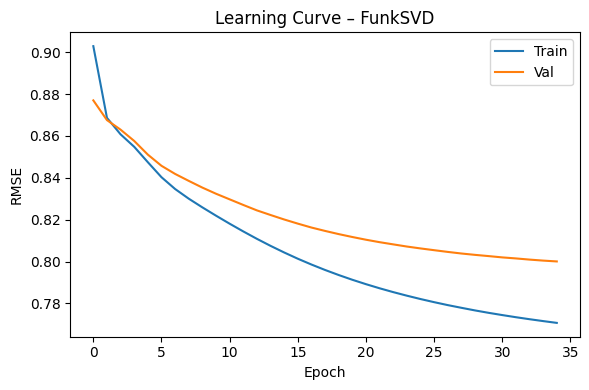

In [19]:
# learning curve
plt.figure(figsize=(6, 4))
plt.plot(model.train_rmse, label="Train")
if model.val_rmse:
    plt.plot(model.val_rmse, label="Val")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Learning Curve – FunkSVD")
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
def evaluate(df_, mdl):
    u, i, r = df_to_numpy(df_)
    pr = mdl.predict_batch(u, i)
    return np.sqrt(mean_squared_error(r, pr)), mean_absolute_error(r, pr)

tr_rmse, tr_mae = evaluate(train_df, model)
vl_rmse, vl_mae = evaluate(val_df, model)
ts_rmse, ts_mae = evaluate(test_df, model)

print(
    f"\nRMSE | MAE\n"
    f"Train: {tr_rmse:.4f} | {tr_mae:.4f}\n"
    f"Val  : {vl_rmse:.4f} | {vl_mae:.4f}\n"
    f"Test : {ts_rmse:.4f} | {ts_mae:.4f}"
)


RMSE | MAE
Train: 0.7691 | 0.5855
Val  : 0.8001 | 0.6073
Test : 0.8005 | 0.6076


In [ ]:
def recommend_movies(user_id_raw, model, N=10):
    """Trả về DataFrame (movieId, title, genres, pred_rating, rating nếu có) cho user chưa xem."""
    
    if user_id_raw not in user_enc.classes_:
        raise ValueError("User ngoài tập huấn luyện!")

    u_idx = user_enc.transform([user_id_raw])[0]

    # Những phim đã xem
    seen = set(df.loc[df['user_idx'] == u_idx, 'movie_idx'])  # phim đã đánh giá

    # Tính điểm dự đoán cho tất cả phim
    scores = (model.mu + model.bi +
              model.bu[u_idx] +
              model.P[u_idx] @ model.Q.T)

    # Lọc các phim chưa xem
    unseen_idx = np.setdiff1d(np.arange(n_items), list(seen)) 

    # Lấy top-N phim có điểm dự đoán cao nhất trong số chưa xem
    best_idx = unseen_idx[np.argsort(scores[unseen_idx])[::-1][:N]] 

    out = pd.DataFrame({
        'movie_idx': best_idx,
        'pred_rating': scores[best_idx]
    })
    out['movieId'] = movie_enc.inverse_transform(out['movie_idx'])

    out = out.merge(movies[['movieId', 'title', 'genres']], on='movieId', how='left') 

    out = out.merge(
        df[df['user_idx'] == u_idx][['movieId', 'rating']],
        on='movieId', how='left'
    )  

    return out[['movieId', 'title', 'genres', 'pred_rating', 'rating']].sort_values(
        'pred_rating', ascending=False
    )

rand_user = 95133
print(f"\nGợi ý Top-10 cho user {rand_user}:")
display(recommend_movies(rand_user, model, N=10))


Gợi ý Top-10 cho user 95133:


,movieId,title,genres,pred_rating,rating
0,171011,Planet Earth II (2016),Documentary,4.317332,NaN
1,170705,Band of Brothers (2001),Action|Drama|War,4.270060,NaN
2,159817,Planet Earth (2006),Documentary,4.260656,NaN
3,142115,The Blue Planet (2001),Documentary,4.255741,NaN
4,159819,Life (2009),Documentary,4.243758,NaN
5,171495,Cosmos,(no genres listed),4.219657,NaN
6,93040,"Civil War, The (1990)",Documentary|War,4.204262,NaN
7,179135,Blue Planet II (2017),Documentary,4.191123,NaN
8,95604,The War (2007),Documentary|War,4.123831,NaN
9,26082,Harakiri (Seppuku) (1962),Drama,4.123343,NaN
